In [2]:
from scipy.signal import spectrogram
import numpy as np
import h5py
import timeit
from sklearn import preprocessing
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# parameters

In [3]:
#time data
sample_rate = 8192
data_length = 8192 
dt = float(1) / sample_rate
T = data_length / sample_rate

#spectrogram data
nitv = 16.0
novl = 8.0
NITV = (sample_rate/nitv)
print(NITV)
NOVL = (NITV*(novl-1)/novl)
print(NOVL)
#window = np.blackman(NITV)
spec_cmap='ocean'

lenf = int(sample_rate/nitv/2+1)
print('lenth of f =',lenf)
lent = int((nitv*T-1)*novl+1)
print('lenth of t =',lent)
totalpix = lenf*lent
print('total pixel=',totalpix)
idx512 = (lenf-1)/8
print('index of 512hz =',idx512)
finalpix = idx512*lent
print('final pixel=',finalpix)

512
448
lenth of f = 257
lenth of t = 121
total pixel= 31097
index of 512hz = 32.0
final pixel= 3872.0


# batch generator

In [4]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] 

# spectrogram generator

In [5]:
def specdatagenerator(datafile,filename):
    #計時
    start_time = timeit.default_timer()
    
    g = h5py.File(datafile,'r') #time domain data
    datanumber = len(g['label'])
    batch = batch_generator(datafile,1)
    
    f = h5py.File(filename,'a')
    f.create_dataset('label', data = g['label'])
    f.create_dataset('data',(datanumber, idx512+1, lent)) #maxshape=(None,None,None))
    try:
        f.create_dataset('parameter', data = g['parameter'])
    except:
        print 'mass parameter doesnt exist'
    g.close()
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    
    for idx in range(0,datanumber):
        freqs, bins, spec_data = spectrogram(next(batch).reshape(-1,), nfft=NITV, fs=sample_rate, window=window, noverlap=NOVL, detrend=False)
        del freqs, bins
        spec_dataf = spec_data.reshape(totalpix,1)
        del spec_data
        specfn = scale.fit_transform(spec_dataf)
        del spec_dataf
        # 只取頻率到512hz的部分
        f['data'][idx] = specfn.reshape(1, lenf, lent)[:, :(idx512+1), :]
        del specfn
            
    
    f.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    print('finish')

val data

In [13]:
prlist = [2,1.5,1.2,1,0.8,0.7,0.6,0.5]
for n in prlist:
    specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75/validationdata_time_pr'+str(n)+'_mr<=10.h5',
                  '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq512_pr'+str(n)+'_mr<=10.h5')

mass parameter doesnt exist
period(s) = 14.959717989
finish
mass parameter doesnt exist
period(s) = 15.5688760281
finish
mass parameter doesnt exist
period(s) = 14.2665760517
finish
mass parameter doesnt exist
period(s) = 14.9510149956
finish
mass parameter doesnt exist
period(s) = 14.8061311245
finish
mass parameter doesnt exist
period(s) = 15.1610438824
finish
mass parameter doesnt exist
period(s) = 16.8220899105
finish
mass parameter doesnt exist
period(s) = 15.7326600552
finish


In [5]:
prlist = [1.7, 1.4, 1.3, 1.1, 0.9, 0.85, 0.75, 0.65, 0.55]
for n in prlist:
    specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75/validationdata_time_pr'+str(n)+'_mr<=10.h5',
                  '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq512_pr'+str(n)+'_mr<=10.h5')

mass parameter doesnt exist
period(s) = 18.4556221962
finish
mass parameter doesnt exist
period(s) = 14.5644688606
finish
mass parameter doesnt exist
period(s) = 17.6502180099
finish
mass parameter doesnt exist
period(s) = 16.5023150444
finish
mass parameter doesnt exist
period(s) = 16.7912068367
finish
mass parameter doesnt exist
period(s) = 16.974601984
finish
mass parameter doesnt exist
period(s) = 16.7527141571
finish
mass parameter doesnt exist
period(s) = 16.6044700146
finish
mass parameter doesnt exist
period(s) = 16.9278249741
finish


training data

In [14]:
for n in prlist:
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5~75/trainingdata_time_pr'+str(n)+'_mr<=10.h5',
                  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(n)+'_mr<=10.h5')

period(s) = 38.9455449581
finish
period(s) = 37.9567210674
finish
period(s) = 37.2877311707
finish
period(s) = 36.9237480164
finish
period(s) = 37.968157053
finish
period(s) = 39.0253999233
finish
period(s) = 37.4290521145
finish
period(s) = 37.7033929825
finish


In [6]:
for n in prlist:
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5~75/trainingdata_time_pr'+str(n)+'_mr<=10.h5',
                  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(n)+'_mr<=10.h5')

period(s) = 33.8775508404
finish
period(s) = 33.9470880032
finish
period(s) = 34.1838498116
finish
period(s) = 35.1090400219
finish
period(s) = 31.6901459694
finish
period(s) = 29.670899868
finish
period(s) = 28.8071358204
finish
period(s) = 29.0386610031
finish
period(s) = 28.8766620159
finish


test data

In [15]:
for n in prlist:
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr'+str(n)+'_mr<=10.h5', 
                  '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(n)+'_mr<=10.h5')

period(s) = 39.3785271645
finish
period(s) = 39.0076231956
finish
period(s) = 39.762253046
finish
period(s) = 41.4780650139
finish
period(s) = 39.977191925
finish
period(s) = 43.6722509861
finish
period(s) = 42.0169270039
finish
period(s) = 40.2135951519
finish


In [7]:
for n in prlist:
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr'+str(n)+'_mr<=10.h5', 
                  '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(n)+'_mr<=10.h5')

period(s) = 28.0810761452
finish
period(s) = 28.1946871281
finish
period(s) = 28.3800208569
finish
period(s) = 30.6191909313
finish
period(s) = 28.6282300949
finish
period(s) = 28.7353317738
finish
period(s) = 35.435541153
finish
period(s) = 38.7925388813
finish
period(s) = 36.350744009
finish


0.0
(33, 121)
[0. 0.]


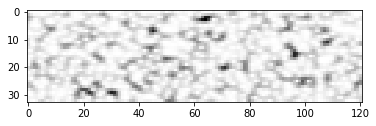

In [26]:
dd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr1.2_mr<=10.h5','r') 
i=1007
plt.imshow(dd['data'][i], cmap='binary')
print dd['label'][i]
print dd['data'][i].shape
print dd['parameter'][i]
dd.close()

In [27]:
m=0.5
for i in range(50):
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr'+str(m)+'_2time10_'+str(i)+'_mr<=10.h5',
                      '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(m)+'_2time10_'+str(i)+'_mr<=10.h5')

period(s) = 27.4275650978
finish
period(s) = 30.2135140896
finish
period(s) = 31.7451989651
finish
period(s) = 28.9059271812
finish
period(s) = 29.5972640514
finish
period(s) = 29.7451519966
finish
period(s) = 29.8790009022
finish
period(s) = 29.6274690628
finish
period(s) = 29.3675789833
finish
period(s) = 28.2623829842
finish
period(s) = 25.9626438618
finish
period(s) = 28.7068779469
finish
period(s) = 29.0282900333
finish
period(s) = 27.7470359802
finish
period(s) = 28.0339419842
finish
period(s) = 30.0427179337
finish
period(s) = 28.3720140457
finish
period(s) = 27.8871848583
finish
period(s) = 27.1625590324
finish
period(s) = 26.8545601368
finish
period(s) = 28.2152528763
finish
period(s) = 28.0061149597
finish
period(s) = 27.5366802216
finish
period(s) = 27.8235499859
finish
period(s) = 27.6018841267
finish
period(s) = 27.0655648708
finish
period(s) = 27.4290599823
finish
period(s) = 27.0108559132
finish
period(s) = 27.2238729
finish
period(s) = 33.5068268776
finish
period(s) = 2

# Classification data

In [6]:
prlist = []
ns=0.1
for i in range(39):
    #print '{0:.2f}   {1:.2f}   {2:.2f}'.format(ns, 1/ns, 1/ns*10)
    prlist.append('{:.2f}'.format(1/ns))
    ns += 0.05
print prlist

['10.00', '6.67', '5.00', '4.00', '3.33', '2.86', '2.50', '2.22', '2.00', '1.82', '1.67', '1.54', '1.43', '1.33', '1.25', '1.18', '1.11', '1.05', '1.00', '0.95', '0.91', '0.87', '0.83', '0.80', '0.77', '0.74', '0.71', '0.69', '0.67', '0.65', '0.62', '0.61', '0.59', '0.57', '0.56', '0.54', '0.53', '0.51', '0.50']


In [8]:
for i in prlist:
    pr=float(i)
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5~75/trainingdata_time_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdata_spec_pr{0}.h5'.format(i))

RuntimeError: Unable to create link (name already exists)

In [9]:
for i in prlist:
    pr=float(i)
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5~75/validationdata_time_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/spec/withoutoverlap/5~75/validationdata_spec_pr{0}.h5'.format(i))

period(s) = 9.22573399544
finish
period(s) = 8.89777517319
finish
period(s) = 8.98969602585
finish
period(s) = 9.19878101349
finish
period(s) = 9.12988591194
finish
period(s) = 9.15826296806
finish
period(s) = 9.17570710182
finish
period(s) = 9.26500797272
finish
period(s) = 8.93912482262
finish
period(s) = 9.23796510696
finish
period(s) = 9.20009016991
finish
period(s) = 9.18686413765
finish
period(s) = 9.0795071125
finish
period(s) = 9.13843107224
finish
period(s) = 8.86544704437
finish
period(s) = 9.05792808533
finish
period(s) = 9.13377404213
finish
period(s) = 8.88401484489
finish
period(s) = 8.78041219711
finish
period(s) = 8.90260696411
finish
period(s) = 9.19536781311
finish
period(s) = 9.23892903328
finish
period(s) = 8.99122190475
finish
period(s) = 9.24713301659
finish
period(s) = 9.14352989197
finish
period(s) = 8.89031600952
finish
period(s) = 9.30998706818
finish
period(s) = 9.1873550415
finish
period(s) = 9.04927611351
finish
period(s) = 9.0562069416
finish
period(s) = 9

In [10]:
for i in prlist:
    pr=float(i)
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdata_spec_pr{0}.h5'.format(i))

period(s) = 24.9265038967
finish
period(s) = 24.4828500748
finish
period(s) = 23.5168869495
finish
period(s) = 28.9496610165
finish
period(s) = 31.9483749866
finish
period(s) = 26.4317369461
finish
period(s) = 23.0766592026
finish
period(s) = 24.6062049866
finish
period(s) = 23.8612048626
finish
period(s) = 24.172011137
finish
period(s) = 23.8346951008
finish
period(s) = 23.3691329956
finish
period(s) = 24.6962380409
finish
period(s) = 23.7540128231
finish
period(s) = 23.4873700142
finish
period(s) = 23.4735450745
finish
period(s) = 24.847358942
finish
period(s) = 23.9954738617
finish
period(s) = 23.6676180363
finish
period(s) = 23.6616611481
finish
period(s) = 26.6247169971
finish
period(s) = 26.2232990265
finish
period(s) = 25.5864808559
finish
period(s) = 27.5648460388
finish
period(s) = 26.1738541126
finish
period(s) = 27.6468880177
finish
period(s) = 29.0433061123
finish
period(s) = 28.724241972
finish
period(s) = 29.3198428154
finish
period(s) = 26.7730770111
finish
period(s) = 2

In [11]:
specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75/finalvalidationdata_time.h5',
                  '/Volumes/Mac/GW/spec/overlap/5~75/finalvalidationdata_spec.h5')
specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75/finaltestdata_time.h5',
                  '/Volumes/Mac/GW/spec/overlap/5~75/finaltestdata_spec.h5')
specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75/finaltrainingdata_time.h5',
                  '/Volumes/Mac/GW/spec/overlap/5~75/finaltrainingdata_spec.h5')

period(s) = 16.7440900803
finish
period(s) = 173.283450842
finish
period(s) = 165.237542152
finish


# PE data

In [9]:
for i in prlist:
    pr=float(i)
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5~75_PE/trainingdata_time_PE_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/spec/withoutoverlap/5~75_PE/trainingdata_spec_PE_pr{0}.h5'.format(i))

period(s) = 36.2833180428
finish
period(s) = 36.5603370667
finish
period(s) = 33.9322860241
finish
period(s) = 34.1458959579
finish
period(s) = 34.1926698685
finish
period(s) = 33.937664032
finish
period(s) = 33.6298251152
finish
period(s) = 33.9859519005
finish
period(s) = 34.2745778561
finish
period(s) = 34.0154881477
finish
period(s) = 34.1672189236
finish
period(s) = 36.5225071907
finish
period(s) = 44.9939761162
finish
period(s) = 43.6631829739
finish
period(s) = 44.5487430096
finish
period(s) = 46.2634620667
finish
period(s) = 47.368901968
finish
period(s) = 45.4099860191
finish
period(s) = 48.8815329075
finish
period(s) = 56.7741501331
finish
period(s) = 56.6294579506
finish
period(s) = 48.1350929737
finish
period(s) = 53.6283249855
finish
period(s) = 53.3461990356
finish
period(s) = 51.7863759995
finish
period(s) = 53.5797669888
finish
period(s) = 54.1969311237
finish
period(s) = 50.9441850185
finish
period(s) = 46.15832901
finish
period(s) = 35.5155580044
finish
period(s) = 34

In [8]:
for i in prlist:
    pr=float(i)
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5_PE/testdata_time_PE_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5_PE/testdata_spec_PE_pr{0}.h5'.format(i))

period(s) = 12.2437138557
finish
period(s) = 11.8599591255
finish
period(s) = 11.7970199585
finish
period(s) = 15.1280698776
finish
period(s) = 12.4290230274
finish
period(s) = 12.299339056
finish
period(s) = 13.1704230309
finish
period(s) = 13.086222887
finish
period(s) = 11.9453601837
finish
period(s) = 11.2273600101
finish
period(s) = 11.4805910587
finish
period(s) = 11.2694251537
finish
period(s) = 12.3362290859
finish
period(s) = 12.553581953
finish
period(s) = 12.173473835
finish
period(s) = 12.9631159306
finish
period(s) = 12.567948103
finish
period(s) = 11.1708059311
finish
period(s) = 11.107708931
finish
period(s) = 11.1563169956
finish
period(s) = 11.2577648163
finish
period(s) = 11.4335839748
finish
period(s) = 11.6631479263
finish
period(s) = 12.0495400429
finish
period(s) = 11.0589101315
finish
period(s) = 11.8446211815
finish
period(s) = 11.3551230431
finish
period(s) = 11.1665949821
finish
period(s) = 11.0694060326
finish
period(s) = 11.335493803
finish
period(s) = 11.32

In [7]:
for i in prlist:
    pr=float(i)
    specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5~75_PE/validationdata_time_PE_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/spec/withoutoverlap/5~75_PE/validationdata_spec_PE_pr{0}.h5'.format(i))

period(s) = 5.31055998802
finish
period(s) = 4.67932701111
finish
period(s) = 4.68821287155
finish
period(s) = 4.98529195786
finish
period(s) = 4.67136597633
finish
period(s) = 5.00875902176
finish
period(s) = 5.07135891914
finish
period(s) = 6.35536813736
finish
period(s) = 5.32045483589
finish
period(s) = 4.83941698074
finish
period(s) = 4.74957489967
finish
period(s) = 5.94477200508
finish
period(s) = 5.92473983765
finish
period(s) = 5.98885989189
finish
period(s) = 4.72079086304
finish
period(s) = 6.35301208496
finish
period(s) = 5.68964982033
finish
period(s) = 4.87722706795
finish
period(s) = 5.50470805168
finish
period(s) = 5.33774089813
finish
period(s) = 5.45487904549
finish
period(s) = 5.20397400856
finish
period(s) = 5.56776881218
finish
period(s) = 5.34259009361
finish
period(s) = 5.31862688065
finish
period(s) = 5.21310997009
finish
period(s) = 4.93152689934
finish
period(s) = 5.06747889519
finish
period(s) = 5.05778002739
finish
period(s) = 5.15315413475
finish
period(s) 

In [11]:
specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75_PE/finaltrainingdata_time_PE.h5', 
              '/Volumes/Mac/GW/spec/overlap/5~75_PE/finaltrainingdata_spec_PE.h5')

period(s) = 295.348781109
finish


In [13]:
specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75_PE/finaltestdata_time_PE.h5', 
              '/Volumes/Mac/GW/spec/overlap/5~75_PE/finaltestdata_spec_PE.h5')

period(s) = 91.8010060787
finish


In [12]:
specdatagenerator('/Volumes/Mac/GW/time/overlap/5~75_PE/finalvalidationdata_time_PE.h5', 
              '/Volumes/Mac/GW/spec/overlap/5~75_PE/finalvalidationdata_spec_PE.h5')

period(s) = 28.7751278877
finish


In [7]:
specdatagenerator('/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_error_relate_mass.h5', 
              '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdata_spec_error_relate_mass.h5')

period(s) = 588.989958048
finish
